Successfully loaded time series data
MAE: 14989630.117149115
MSE: 228559110492009.47


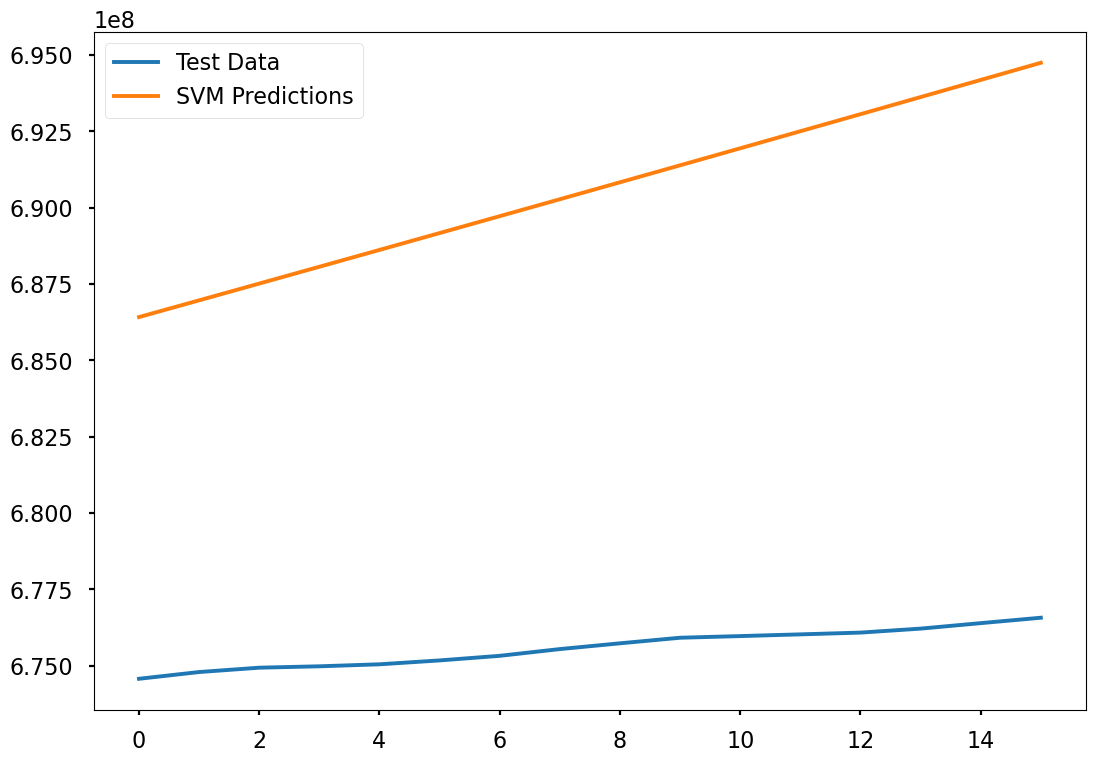

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
%matplotlib inline
import warnings

# Update matplotlib style for newer versions
try:
    plt.style.use('seaborn-v0_8-poster')  # For matplotlib 3.6 and newer
except:
    try:
        plt.style.use('seaborn-poster')  # For older matplotlib versions
    except:
        print("Using default matplotlib style")
        
warnings.filterwarnings("ignore")

# Define data URLs
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
# Use more recent date that's more likely to exist in the repository
latest_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-01-2023.csv'

# Add error handling for data loading
try:
    confirmed_df = pd.read_csv(confirmed_url)
    deaths_df = pd.read_csv(deaths_url)
    
    try:
        latest_data = pd.read_csv(latest_url)
    except Exception as e:
        print(f"Warning: Could not load latest data: {e}")
        print("Trying alternative date...")
        # Try an older date as fallback
        latest_url_fallback = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/12-31-2022.csv'
        try:
            latest_data = pd.read_csv(latest_url_fallback)
            print(f"Successfully loaded fallback data from {latest_url_fallback}")
        except:
            print("Could not load fallback data either. Using empty DataFrame for latest_data.")
            latest_data = pd.DataFrame()
    
except Exception as e:
    print(f"Error loading data: {e}")
    # Create empty DataFrames to prevent script failure
    confirmed_df = pd.DataFrame()
    deaths_df = pd.DataFrame()
    latest_data = pd.DataFrame()

# Add additional error checking
if not confirmed_df.empty and not deaths_df.empty:
    print("Successfully loaded time series data")
    latest_data.head()
    confirmed_df.head()
    
    confirmed_cols = confirmed_df.keys()
    deaths_cols = deaths_df.keys()
else:
    print("ERROR: Failed to load required data files. Please check your internet connection.")
    # Create minimal structure to prevent further errors
    confirmed_cols = []
    deaths_cols = []

# Add additional error handling for data extraction
try:
    if len(confirmed_cols) >= 5 and len(deaths_cols) >= 5:
        confirmed = confirmed_df.loc[:, confirmed_cols[4]:]
        deaths = deaths_df.loc[:, deaths_cols[4]:]
    else:
        print("ERROR: Data format is not as expected. Creating empty DataFrames.")
        confirmed = pd.DataFrame()
        deaths = pd.DataFrame()
except Exception as e:
    print(f"ERROR: Failed to process data: {e}")
    confirmed = pd.DataFrame()
    deaths = pd.DataFrame()

num_dates = len(confirmed.keys())
ck = confirmed.keys()
dk = deaths.keys()

world_cases = []
total_deaths = [] 
mortality_rate = []


for i in range(num_dates):
    confirmed_sum = confirmed[ck[i]].sum()
    death_sum = deaths[dk[i]].sum()
    
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

days_since_1_22 = np.array([i for i in range(len(ck))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)   

days_in_future = 10
future_forcast = np.array([i for i in range(len(ck)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

# slightly modify the data to fit the model better (regression models cannot pick the pattern), we are using data from 8/1/22 and onwards for the prediction modeling 
days_to_skip = 922
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[days_to_skip:], world_cases[days_to_skip:], test_size=0.07, shuffle=False) 

# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [ ]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.transform(X_test_confirmed)
poly_future_forcast = poly.transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=3)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.transform(future_forcast)

In [ ]:
# This cell was redundant and has been removed as Cell 1 already handles data transformation


In [53]:
# polynomial regression - using StandardScaler instead of deprecated normalize=True
# Scale the features
scaler = StandardScaler()
scaled_poly_X_train = scaler.fit_transform(poly_X_train_confirmed)
scaled_poly_X_test = scaler.transform(poly_X_test_confirmed)
scaled_poly_future = scaler.transform(poly_future_forcast)

# Train the model without deprecated parameter
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(scaled_poly_X_train, y_train_confirmed)
test_linear_pred = linear_model.predict(scaled_poly_X_test)
linear_pred = linear_model.predict(scaled_poly_future)

print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:', mean_squared_error(test_linear_pred, y_test_confirmed))

print('Model coefficients:', linear_model.coef_)

NameError: name 'StandardScaler' is not defined

NameError: name 'test_linear_pred' is not defined

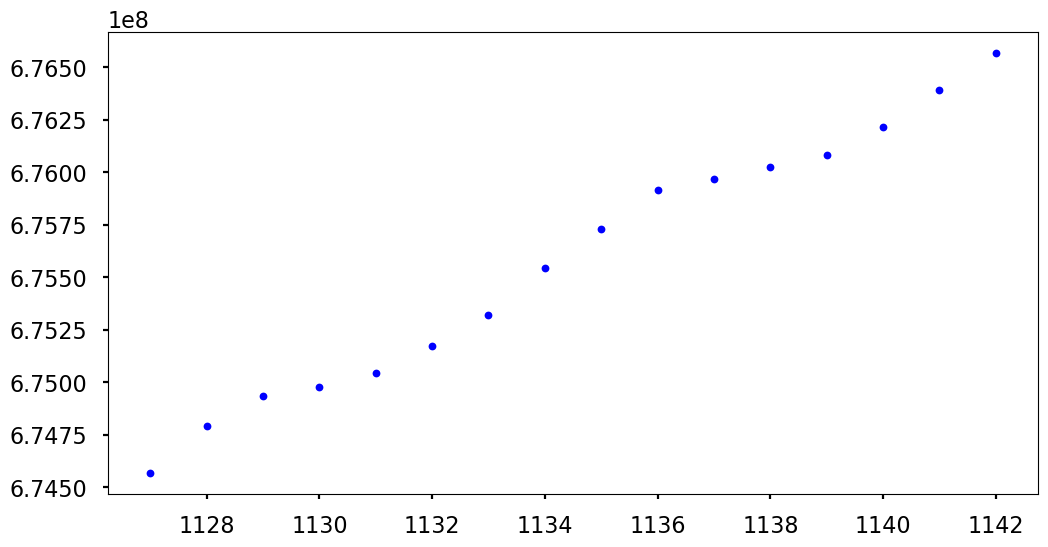

In [57]:
# Visualize polynomial regression results - test data vs predictions
plt.figure(figsize=(12, 6))
plt.plot(X_test_confirmed, y_test_confirmed, 'b.', label='Actual Test Data')
plt.plot(X_test_confirmed, test_linear_pred, 'r-', label='Polynomial Regression Predictions')
plt.title('Polynomial Regression: Test Data vs Predictions')
plt.xlabel('Days since 1/22/2020')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'linear_pred' is not defined

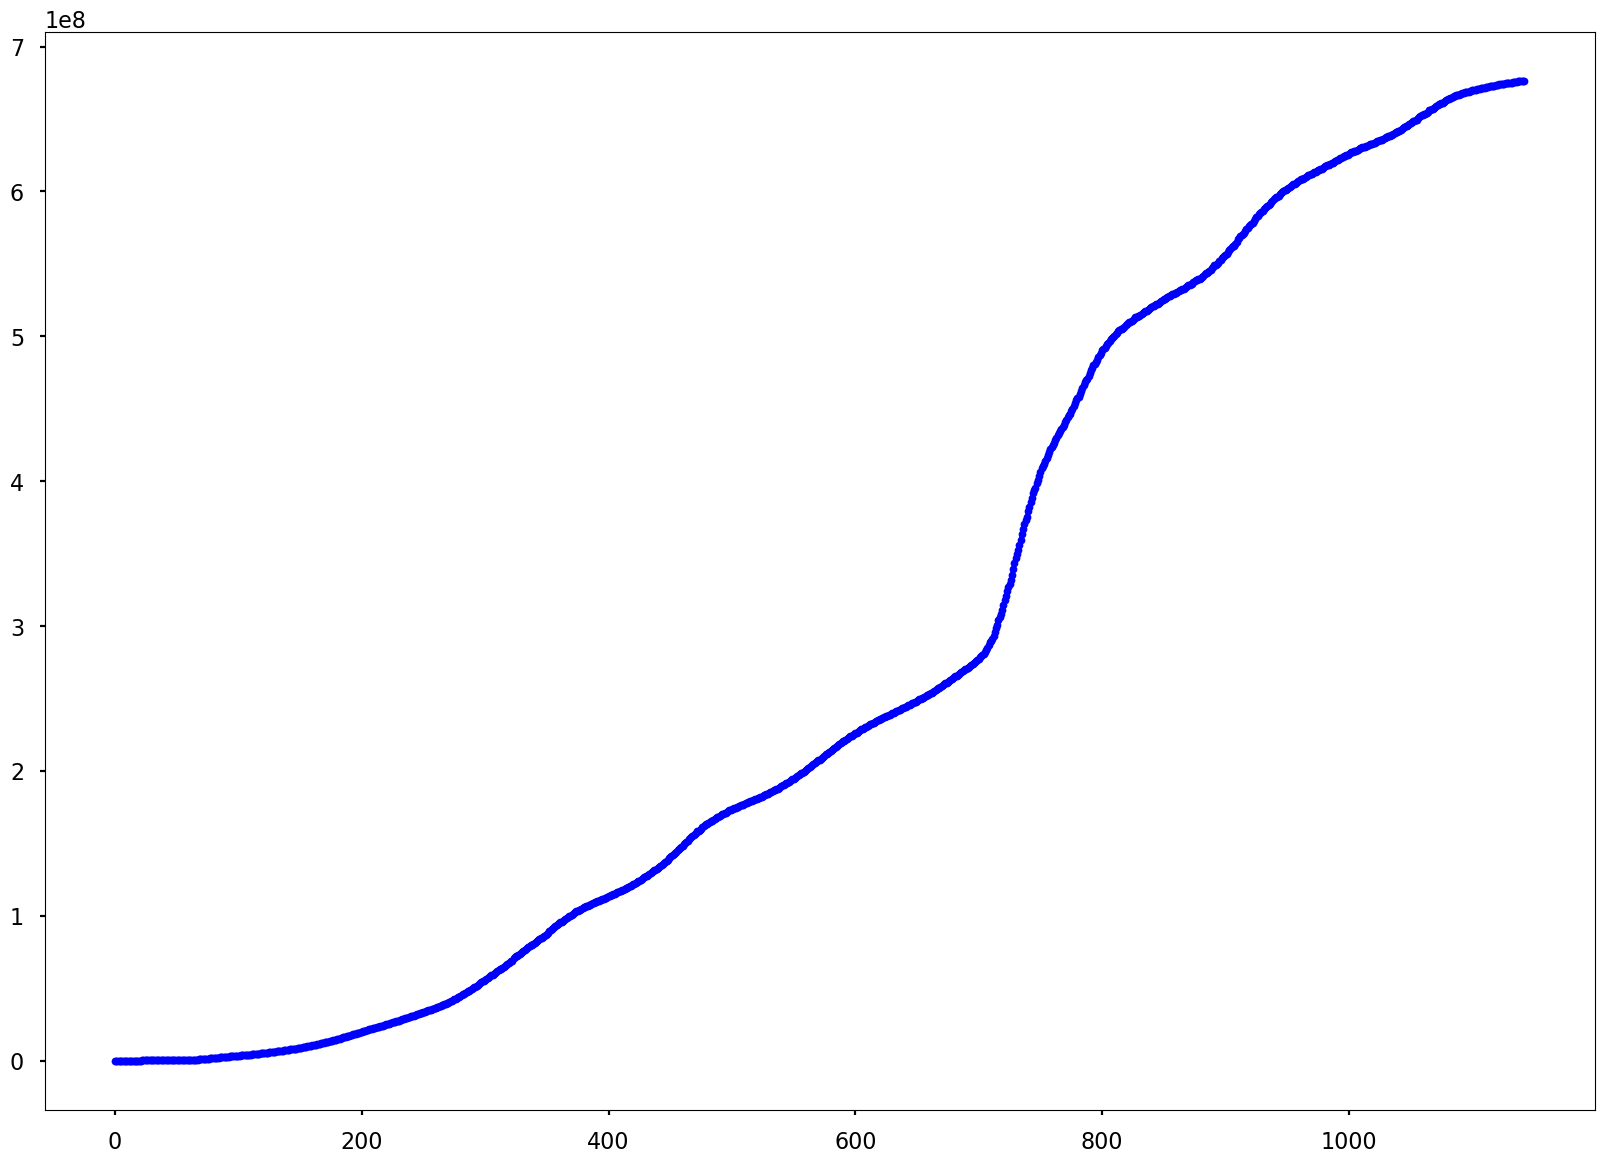

In [66]:
# Visualize forecast for future days with all models
plt.figure(figsize=(20, 14
                    ))
plt.plot(adjusted_dates, world_cases, 'b.-', label='Historical Cases')
plt.plot(future_forcast, linear_pred, 'r--', label='Polynomial Regression Forecast')
plt.plot(future_forcast, svm_pred, 'g--', label='SVR Forecast')
plt.plot(future_forcast, bayesian_pred, 'm--', label='Bayesian Ridge Forecast')
plt.title('COVID-19 Cases Forecast')
plt.xlabel('Days since 1/22/2020')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Implement Bayesian Ridge Regression that was previously defined but unused
# Create and fit the Bayesian Ridge model
bayesian_model = BayesianRidge(compute_score=True)
bayesian_model.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

# Make predictions
bayesian_test_pred = bayesian_model.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_model.predict(bayesian_poly_future_forcast)


# Print evaluation metrics
print('Bayesian Ridge Regression Metrics:')
print('MAE:', mean_absolute_error(bayesian_test_pred, y_test_confirmed))
print('MSE:', mean_squared_error(bayesian_test_pred, y_test_confirmed))
print('Alpha:', bayesian_model.alpha_)
print('Lambda:', bayesian_model.lambda_)


Bayesian Ridge Regression Metrics:
MAE: 13667204.510766968
MSE: 190688913110714.03
Alpha: 6.760046722191428e-14
Lambda: 48.051385816766114


NameError: name 'test_linear_pred' is not defined

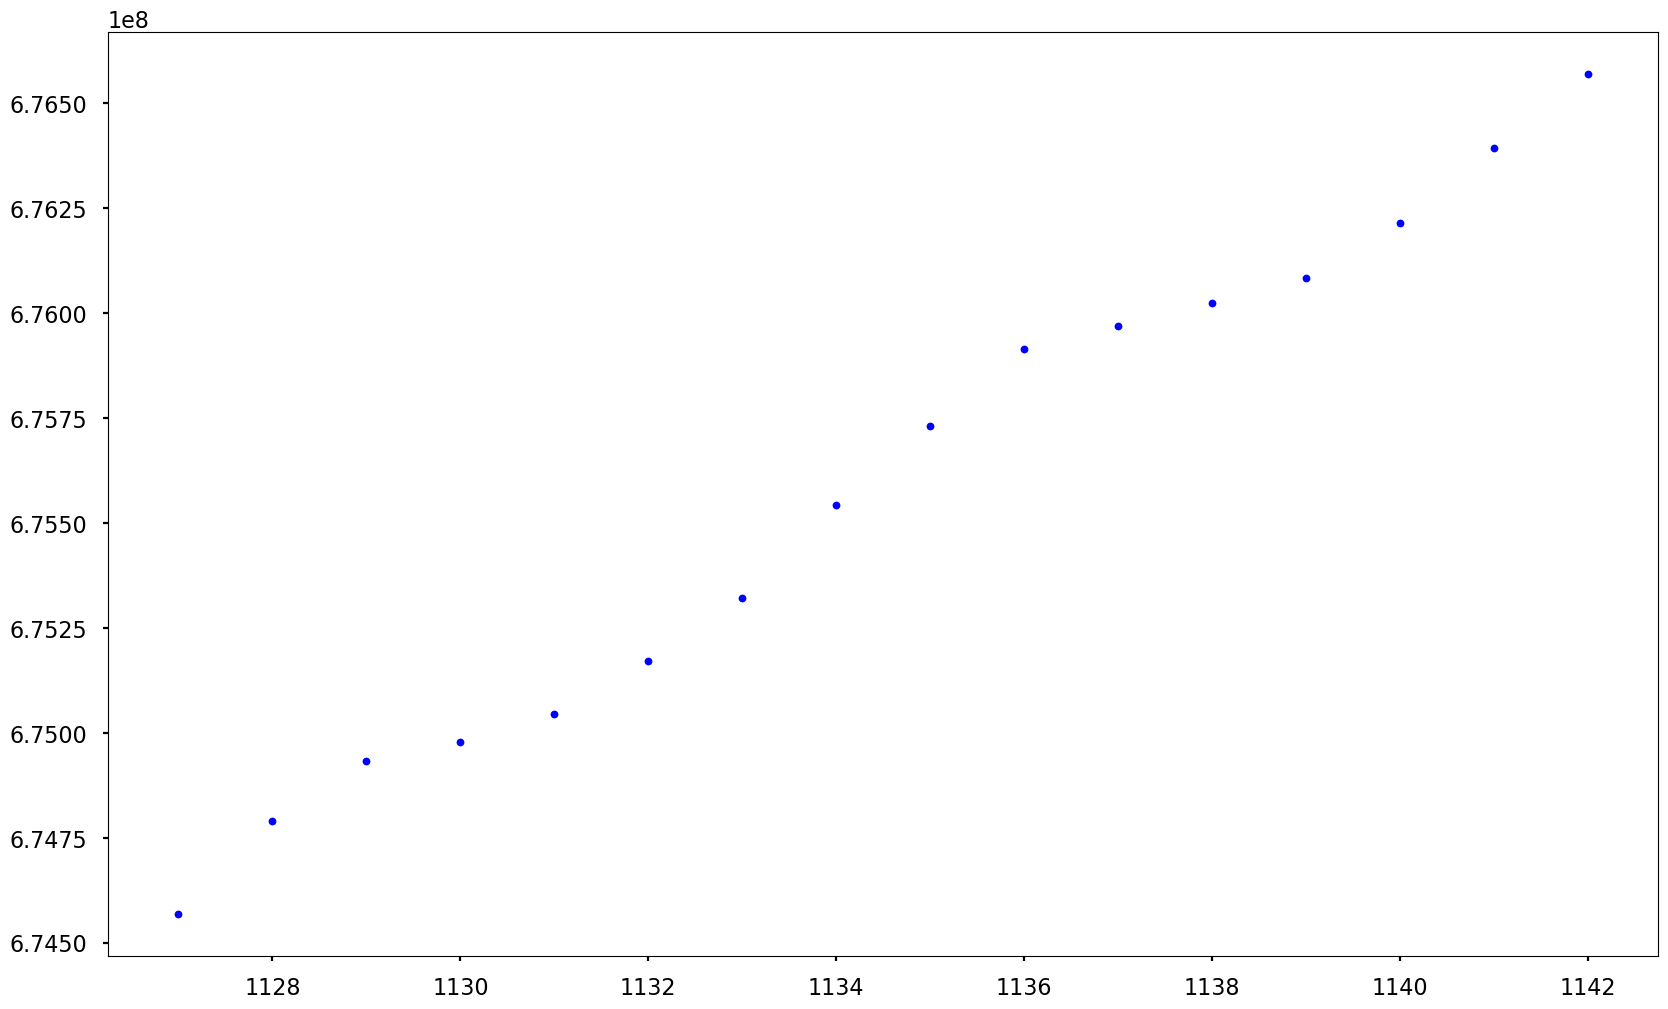

In [64]:
# Visualize Bayesian Ridge Regression predictions with other models
plt.figure(figsize=(20, 12))
plt.plot(X_test_confirmed, y_test_confirmed, 'b.', label='Actual Test Data')
plt.plot(X_test_confirmed, test_linear_pred, 'r-', label='Polynomial Regression')
plt.plot(X_test_confirmed, bayesian_test_pred, 'g-', label='Bayesian Ridge Regression')
plt.title('Model Comparison on Test Data')
plt.xlabel('Days since 1/22/2020')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# Required package versions for reproducibility
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib

# Display package versions
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-Learn: {sklearn.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print("\nScikit-Learn Models Used: LinearRegression, BayesianRidge, SVR")
print("Preprocessing: PolynomialFeatures, StandardScaler")
print("Metrics: mean_absolute_error, mean_squared_error")


Python: 3.11.5
NumPy: 1.24.3
Pandas: 2.0.3
Scikit-Learn: 1.3.0
Matplotlib: 3.7.2

Scikit-Learn Models Used: LinearRegression, BayesianRidge, SVR
Preprocessing: PolynomialFeatures, StandardScaler
Metrics: mean_absolute_error, mean_squared_error


NameError: name 'linear_model' is not defined